# FIGURE 1

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns; sns.set(color_codes=True)
from msresist.pre_processing import preprocessing, LinearFoldChange, FoldChangeToControl, MapOverlappingPeptides, BuildMatrix, CorrCoefFilter, TripsMeanAndStd, FilterByStdev, MergeDfbyMean
from msresist.sequence_analysis import pYmotifs, FormatName, FormatSeq
import warnings
warnings.simplefilter("ignore")

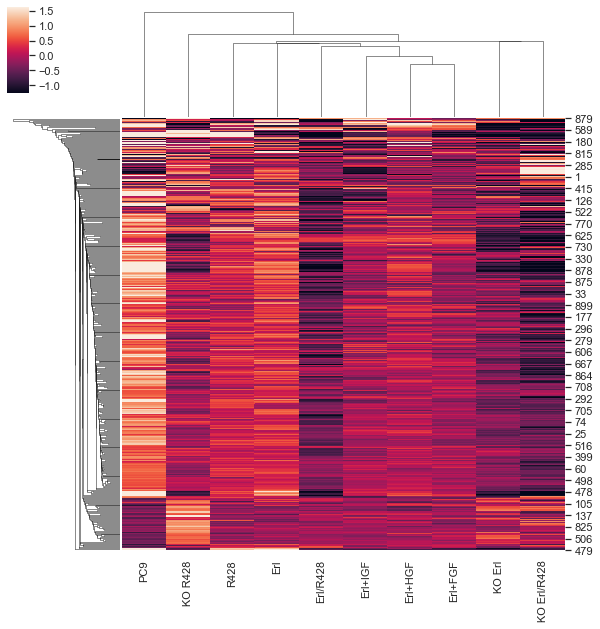

In [2]:
ABC_mc = preprocessing(motifs=True, FCfilter=True, log2T=True)

g = sns.clustermap(ABC_mc.iloc[:, 3:13], method = "single", robust=True)
# plt.savefig("Heatmap.jpg")

In [3]:
Y_cv1 = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw3.csv').iloc[:30, :11]
Y_cv2 = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw4.csv').iloc[:29, :11]

for ii in range(1, Y_cv2.columns.size):
    Y_cv1.iloc[:, ii] /= Y_cv1.iloc[0, ii]
    Y_cv2.iloc[:, ii] /= Y_cv2.iloc[0, ii]

Y_cv = MergeDfbyMean(pd.concat([Y_cv1, Y_cv2], axis=0), Y_cv1.columns, "Elapsed")
Y_cv = Y_cv.reset_index()[Y_cv1.columns]
Y_cv = Y_cv[Y_cv["Elapsed"] == 72].iloc[0, 1:]

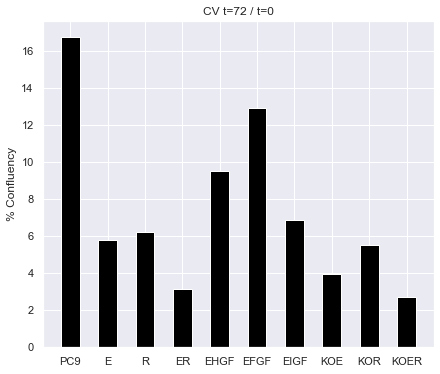

In [4]:
fig, ax = plt.subplots(1,1,figsize=(7,6))


range_ = np.linspace(1, 10, 10)

ax.set_title("CV t=72 / t=0")
ax.set_xticks(np.arange(1,11,1))
ax.set_xticklabels(Y_cv1.columns[1:])
ax.bar(range_, Y_cv, width=0.5, align='center', label='Exp3', color = "black")
ax.set_ylabel("% Confluency")
# plt.savefig("CV_Avg3&4_72h.pdf")